<center style="color:#6495ED">
    <h1>
        Workshop for Data Scientist Final Project <br />
        Sequence Generation with Keras
    </h1>
    
    <h2>
        By Alon Galperin & Matan Yeshurun
    </h2>
</center>

## Prerequisite for running the code

1. Python 2.7.10
2. Anaconda 2.7.14 (64-bit)
3. Install Keras

libraries import:

In [129]:
import pandas as pd
import numpy as np
import random
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

# algorithms:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

Our project is on the subject of song lyrics classification and generation.

# Part A: Collecting Data  
  
We will use the Kaggle song corpus, given free in Kaggle website after login to the site:  
https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics/data
  
### Corpus Content:
There are around 380,000+ lyrics in the data set from a lot of different artists from a lot of different genres arranged by year.  
The corpus is provided as csv file.  
__Structure:__  

| Attribute | type |
|:------------- |:------------- |
| index      | numeric |
| song      | string |
| year      | numeric |
| artist      | string |
| genre      | string |
| lyrics      | string |  

Load the dataset from csv using Pandas

In [179]:
lyrics = pd.read_csv('./collected_from_internet/lyrics.csv')

print('we loaded %d records' %len(lyrics))

we loaded 362237 records


### Check the five records to see how the data looks

In [131]:
print lyrics.head()

   index             song  year           artist genre  \
0      0        ego-remix  2009  beyonce-knowles   Pop   
1      1     then-tell-me  2009  beyonce-knowles   Pop   
2      2          honesty  2009  beyonce-knowles   Pop   
3      3  you-are-my-rock  2009  beyonce-knowles   Pop   
4      4    black-culture  2009  beyonce-knowles   Pop   

                                              lyrics  
0  Oh baby, how you doing?\nYou know I'm gonna cu...  
1  playin' everything so easy,\nit's like you see...  
2  If you search\nFor tenderness\nIt isn't hard t...  
3  Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...  
4  Party the people, the people the party it's po...  


### Check how many records there are with missing lyrics

In [132]:
lyrics.apply(lambda x: sum(x.isnull()),axis=0)

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

We can see that we have 95,680 records with missing lyrics.  
We will Drop these records

In [133]:
lyrics.dropna(subset=['lyrics'], inplace=True)

print('now we have %d records' %len(lyrics))

now we have 266557 records


# The artists we want to classify are: Eminem, Beyonce-Knowles and Arctic-Monkeys

Check how many songs of the artists we have:

In [134]:
print ('Eminem has %d songs' % len(lyrics.loc[lyrics['artist'] == 'eminem']))
print ('Beyonce has %d songs' % len(lyrics.loc[lyrics['artist'] == 'beyonce-knowles']))
print ('Arctic-Monkeys has %d songs' % len(lyrics.loc[lyrics['artist'] == 'arctic-monkeys']))

Eminem has 578 songs
Beyonce has 248 songs
Arctic-Monkeys has 134 songs


We can see that the lowest number of songs is the number of Arctic Monkeys songs, so we will take **130** songs from each artist.  
We will concat all the 3 artists lyrics to 1 dataset

In [135]:
eminem_songs = lyrics.loc[lyrics['artist'] == 'eminem'][:130]

beyonce_songs = lyrics.loc[lyrics['artist'] == 'beyonce-knowles'][:130]

arctic_monkeys_songs = lyrics.loc[lyrics['artist'] == 'arctic-monkeys'][:130]

total_songs = eminem_songs.append([beyonce_songs,arctic_monkeys_songs])
print('our total songs has %d songs' % len(total_songs))

our total songs has 390 songs


In [136]:
def avg_song_chars_count(lyrics):
    sum_chars = 0
    for index, row in lyrics.iterrows():
        sum_chars += len(row['lyrics'])
    return sum_chars / len(lyrics)

def avg_song_word_count(lyrics):
    sum_words = 0
    for index, row in lyrics.iterrows():
        sum_words += len(row['lyrics'].split())
    return sum_words / len(lyrics)

print ('avg song length of Eminem chars: %d words: %d' % (avg_song_chars_count(eminem_songs) , avg_song_word_count(eminem_songs)))
print ('avg song length of Beyonce chars: %d words %d' % (avg_song_chars_count(beyonce_songs) , avg_song_word_count(beyonce_songs)))
print ('avg song length of Arctic Monkeys chars: %d words: %d' % ( avg_song_chars_count(arctic_monkeys_songs) , avg_song_word_count(arctic_monkeys_songs)))

avg song length of Eminem chars: 3231 words: 644
avg song length of Beyonce chars: 1909 words 390
avg song length of Arctic Monkeys chars: 1206 words: 234


## save songs to csv
Maybe it will be usful in next stages

In [137]:
eminem_songs.to_csv('eminem_original.csv', sep=',')
beyonce_songs.to_csv('beyonce_original.csv', sep=',')
arctic_monkeys_songs.to_csv('arctic_original.csv', sep=',')

## Data Preparation and Cleaning:  
**The steps of preparation and cleaning are:**
1.  Change the text format to uff-8.
2.  Change the text to lower-case.
3.  Tokenize the sentences to words token.
4.  Stop words removal. We also remove puncuation (using python puncuation list string.punctuation)
5.  Stem the words using Porter Stemmer.
6.  Last step we will concat the sentence together

In [138]:
word_punct_tokenizer = WordPunctTokenizer() # from nltk.tokenize
stop_words = stopwords.words('english') + list(string.punctuation)
ps = PorterStemmer()

def clean_and_prepare(text):
    text = text.decode("utf-8")
    text = text.lower()
    text_tokens = word_punct_tokenizer.tokenize(text)
    meaningful_words  = [w for w in text_tokens if not w in stop_words]
    stemmed_text = []
    for word in meaningful_words :
        stem = ps.stem(word)
        stemmed_text.append(stem)
    text = ' '.join(stemmed_text)
    return text

### Check how the dataset head lyrics look like before and after the preparation

In [139]:
print('Before preparation:')
print total_songs['lyrics'].head()
print('')

# sending the lyrics column to preparation function
for index, row in total_songs.iterrows():
    total_songs.loc[index, "lyrics"] = clean_and_prepare(row['lyrics'])

print('After preparation:')
print total_songs['lyrics'].head()

Before preparation:
313004    Ya look\nIf I were to rap about the crap that'...
313005    All aboard, okay, next stop, my basement, haha...
313006    You are now listening to the sounds of...Shady...
313007    Yeah\nMake my vocals sound sexy\nCome on man, ...
313008    Going back to the corner where I first saw you...
Name: lyrics, dtype: object

After preparation:
313004    ya look rap crap rout probabl want take caus d...
313005    aboard okay next stop basement haha meet say u...
313006    listen sound ... shadi ... alchemist .. alchem...
313007    yeah make vocal sound sexi come man come man o...
313008    go back corner first saw gonna camp sleep bag ...
Name: lyrics, dtype: object


check avg length of song

In [140]:
eminem_songs = total_songs.loc[lyrics['artist'] == 'eminem']
beyonce_songs = total_songs.loc[lyrics['artist'] == 'beyonce-knowles']
arctic_songs = total_songs.loc[lyrics['artist'] == 'arctic-monkeys']

def avg_song_length(lyrics):
    sum = 0
    for index, row in lyrics.iterrows():
        sum += len(row['lyrics'])
    return sum / 130

print ('avg song length of Eminem %d' % avg_song_length(eminem_songs))
print ('avg song length of Beyonce %d' % avg_song_length(beyonce_songs))
print ('avg song length of Arctic Monkeys %d' % avg_song_length(arctic_songs))

avg song length of Eminem 1799
avg song length of Beyonce 1054
avg song length of Arctic Monkeys 622


In [141]:
print len(total_songs)

390


# Part B: Building Models and Classification

first we shuffle the records in the dataset. So we have mix of artists in the train and test set

In [142]:
total_songs = total_songs.reindex(np.random.permutation(total_songs.index))

### Split the dataset to train and test sets:

In [143]:
df_train, df_test = train_test_split(total_songs, test_size=0.2)

x_train = df_train['lyrics']
y_train = df_train['artist']

x_test = df_test['lyrics']
y_test = df_test['artist']

In [144]:
print('number of records in train: %d' %len(df_train))
print('number of records in test: %d' %len(df_test))

number of records in train: 312
number of records in test: 78


## Prepare the data for classification algorithms
### We will transform the data from domain of words(strings) to numric domain.
The reason is that almost all of the algorithms can handle only numric input and not string.  
The method that we are going to use called TFIDF (as learned in lesson 12).  
TFIDF will convert the domain from world of string and words to world of ** document frequency**. The number is  
the matrix will represent statistic that will reflect how important a word is to the songs collection.  
  
**Also**  the matrix will be sparse, that mean that it be effient in space and it won't have entries for values  
that are null in the frequency table.  
We won't define value for this, we let the TFIDF algorithm decide what is the best configuration for this value.  
That is since we didn't dive to deep to  this subject during our course and we don't what to set a value that is to small for  
the english dictionary.

In [145]:
tfidfVectorizer = TfidfVectorizer()

x_train = tfidfVectorizer.fit_transform(x_train)
x_test = tfidfVectorizer.transform(x_test)

print the x_train details:

In [146]:
x_train

<312x7198 sparse matrix of type '<type 'numpy.float64'>'
	with 35285 stored elements in Compressed Sparse Row format>

### Change target attribute from words to numbers
In this step we will change the values in the target attribute from words (strings)  
to numric.  
Example: If we have target attribute of singers so we will change each singer name with a number  
Ed Sheeran -> 1  
The Cranberries -> 2  
Metallica -> 3  
  
We will use LabelEncoder of NLTK to do this task (as learned in lesson 8).

In [147]:
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [148]:
list(le.classes_)

['arctic-monkeys', 'beyonce-knowles', 'eminem']

## Train and Test using Classification Algorithms:
### Random Forest:

In [149]:
algorithm_results = [] # array that will contain the results of the algorithms

In [150]:
random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Predict and get the score of Random Forest:

In [151]:
score = random_forest.score(x_test, y_test)
print ('the score is: %f'  %score)

algorithm_results.append(('Random Forest', score))

the score is: 0.858974


### LinearSVC:
This is variation of Support Vector Machine, considered to work well on text classification

In [152]:
svc = LinearSVC(penalty="l1", dual=False, tol=1e-3)
svc.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.001,
     verbose=0)

#### Predict and get the score of LinearSVC:

In [153]:
score = svc.score(x_test, y_test)
print ('the score is: %f'  %score)

algorithm_results.append(('LinearSVC', score))

the score is: 0.730769


### Naive Bayes using Gaussian function (GaussianNB)

In [154]:
gaussianNB = GaussianNB()

x_train_not_dense = x_train.toarray() # Naive Bayes not working on dense matries

gaussianNB.fit(x_train_not_dense, y_train)

GaussianNB(priors=None)

#### Predict and get the score of Naive Baye:

In [155]:
x_test_not_dense = x_test.toarray() # Naive Bayes not working on dense matries

score = gaussianNB.score(x_test_not_dense, y_test)
print ('the score is: %f'  %score)

algorithm_results.append(('GaussianNB', score))

the score is: 0.474359


### Nural Network (not Keras)

In [156]:
from sklearn.neural_network import MLPClassifier
mlpClassifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlpClassifier.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

#### Predict and get the score of Nural network:

In [157]:
x_test_not_dense = x_test.toarray() # mlpClassifier not working on dense matries so we enter the original x_test

score = mlpClassifier.score(x_test_not_dense, y_test)
print ('the score is: %f'  %score)

algorithm_results.append(('Nural network', score))

the score is: 0.782051


### Plot results comparison:

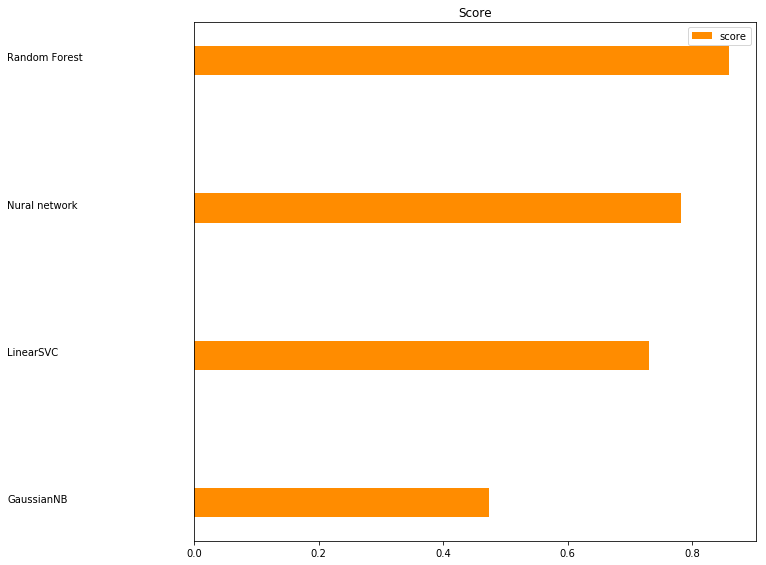

In [158]:
algorithm_results.sort(key=lambda tup: tup[0])  # sorts in place

indices = np.arange(len(algorithm_results))
results = [[x[i] for x in algorithm_results] for i in range(2)]

clf_names, score = results

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

We can see that Random Forest is leading with the best score

# Part C Songs Generation

import keras
from keras.models import Sequential
from keras.layers import Activation,LSTM,Dense
from keras.optimizers import Adam

### Read All Songs

In [ ]:
all_songs_original = pd.read_csv('./collected_from_internet/lyrics.csv')

Create array of 50 songs

In [ ]:
ds = all_songs_original.loc[all_songs_original['artist'] == 'arctic-monkeys']
ds = ds['lyrics']
ds = ds [:50]
songs_lyrics_array = np.array(ds)

concat all lyrics to one text

In [ ]:
txt=''
for ix in range(len(songs_lyrics_array)):
    try:
        txt+=songs_lyrics_array[ix]
    except:
        print ('cant read: ')
        print (songs_lyrics_array[ix])

Create vocab

In [ ]:
vocab=list(set(txt))
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

In [ ]:
maxlen=40
vocab_size=len(vocab)

In [ ]:
sentences=[]
next_char=[]
for i in range(len(txt)-maxlen-1):
    sentences.append(txt[i:i+maxlen])
    next_char.append(txt[i+maxlen])

In [ ]:
X=np.zeros((len(sentences),maxlen,vocab_size))
y=np.zeros((len(sentences),vocab_size))
for ix in range(len(sentences)):
    y[ix,char_ix[next_char[ix]]]=1
    for iy in range(maxlen):
        X[ix,iy,char_ix[sentences[ix][iy]]]=1

In [ ]:
model=Sequential()
model.add(LSTM(128,input_shape=(maxlen,vocab_size)))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.summary()
model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')

In [ ]:
model.fit(X,y,epochs=20,batch_size=128)

In [ ]:
def generate_song():
    generated=''
    start_index=random.randint(0,len(txt)-maxlen-1)
    sent=txt[start_index:start_index+maxlen]
    generated+=sent
    for i in range(1900):
        x_sample=generated[i:i+maxlen]
        x=np.zeros((1,maxlen,vocab_size))
        for j in range(maxlen):
            x[0,j,char_ix[x_sample[j]]]=1
        probs=model.predict(x)
        probs=np.reshape(probs,probs.shape[1])
        ix=np.random.choice(range(vocab_size),p=probs.ravel())
        generated+=ix_char[ix]
    return generated

In [ ]:
df_songs_generated = pd.DataFrame(columns=['lyrics'])
counter = 0

while (counter < 130):
    generated_song = generate_song()
    df_songs_generated.loc[counter] = generated_song
    counter += 1
    print (counter)

In [ ]:
df_songs_generated.to_csv('./generated_songs/arctic-monkeys_song_generated.csv', sep=',')

# Part D Run classification algorithm on generated songs

In [180]:
eminem_generated_songs = pd.read_csv('./generated_songs/eminem_song_generated.csv')
beyonce_generated_songs = pd.read_csv('./generated_songs/beyonce-knowles_song_generated.csv')
arctic_monkeys_generated_songs = pd.read_csv('./generated_songs/arctic-monkeys_song_generated.csv')

In [160]:
total_generated_songs = eminem_generated_songs.append([beyonce_generated_songs,arctic_monkeys_generated_songs])

In [161]:
total_generated_songs.reset_index(drop=True, inplace=True)

In [162]:
total_generated_songs.head()

,Unnamed: 0,artist,lyrics
0,0.0,eminem,"e there's fire, there's flames\r\nWhere the mo..."
1,1.0,eminem,jump in mud puddles\r\nWhile I stomp mud havi...
2,2.0,eminem,round the bottom\r\nAnd make sure I got all R...
3,3.0,eminem,t holiday\r\nHave Michael Myers looking like i...
4,4.0,eminem,you\r\nthe artificial flavors all around your...


In [163]:
total_generated_songs = total_generated_songs.reindex(np.random.permutation(total_generated_songs.index))

In [164]:
total_generated_songs.head()

,Unnamed: 0,artist,lyrics
138,NaN,arctic-monkeys,your eyes\r\nWatching a stripper and\r\n(Smack...
117,NaN,arctic-monkeys,a slag\r\nThe best you ever had\r\nThe best y...
109,NaN,arctic-monkeys,\r\nBut you know what it's like to hold the sl...
115,NaN,arctic-monkeys,"e you did\r\nWell I went outside, couldn't see..."
49,49.0,eminem,studio i gotta get a take done put all and tw...


In [165]:
# sending the lyrics column to preparation function
for index, row in total_generated_songs.iterrows():
    total_generated_songs.loc[index, "lyrics"] = clean_and_prepare(row['lyrics'])

In [166]:
x_test = total_generated_songs['lyrics']

In [167]:
# print ((x_test))

In [168]:
x_test = tfidfVectorizer.transform(x_test)

In [169]:
y_test = total_generated_songs['artist']
y_test = le.transform(y_test)

In [170]:
print ((y_test))

[0 0 0 0 2 0 2 1 2 0 1 0 2 0 2 0 1 2 1 0 0 2 2 2 1 2 1 2 1 1 0 1 0 1 0 1 0
 2 2 0 0 0 1 2 1 1 1 1 0 1 1 2 2 0 0 0 1 2 1 2 2 1 0 0 0 0 2 2 2 2 0 2 0 0
 0 0 1 1 2 0 2 0 2 1 1 2 2 0 2 0 0 2 1 2 0 1 2 0 1 1 1 0 0 1 1 2 1 2 0 1 1
 2 0 2 2 1 1 2 2 2 1 1 2 0 1 1 0 2 0 1 2 2 1 0 0 2 0 1 2 2 2 2 1 0 1 0 1 1
 1 1]


In [171]:
# lst = []
# cols = ['artist']

# for x in range(0, 50):
#     lst.append('eminem')
    
# y_test = pd.DataFrame(lst, columns=cols)

In [172]:
# y_test = le.transform(y_test)
# y_test

In [173]:
score = random_forest.score(x_test, y_test)
print ('the score is: %f'  %score)

the score is: 0.953333


In [174]:
y_pred = random_forest.predict(x_test)

In [175]:
print (y_pred)

[0 0 0 0 2 0 2 1 2 0 1 0 2 0 2 0 1 2 1 1 0 2 2 2 1 2 1 2 1 1 0 1 0 1 0 1 0
 2 2 0 0 0 1 2 1 1 1 1 0 1 1 2 2 1 0 0 1 2 1 2 2 1 0 0 0 0 2 2 2 2 0 2 1 0
 0 1 1 1 2 0 2 0 2 1 1 0 2 0 2 0 0 2 1 2 0 1 2 0 1 1 1 0 0 1 1 2 1 1 0 1 1
 0 0 2 2 1 1 2 2 2 1 1 2 0 1 1 0 2 0 1 2 2 1 0 0 2 0 1 2 2 2 2 1 0 1 0 1 1
 1 1]


In [176]:
from sklearn.metrics import confusion_matrix

In [177]:
y_true = y_test
confusion_matrix(y_true, y_pred)

array([[46,  4,  0],
       [ 0, 50,  0],
       [ 2,  1, 47]], dtype=int64)

Confusion matrix, without normalization
[[46  4  0]
 [ 0 50  0]
 [ 2  1 47]]
Normalized confusion matrix
[[ 0.92  0.08  0.  ]
 [ 0.    1.    0.  ]
 [ 0.04  0.02  0.94]]


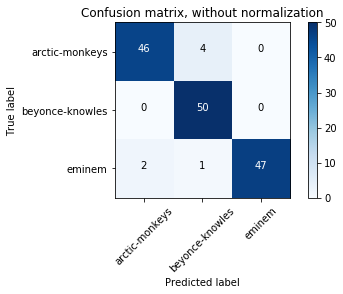

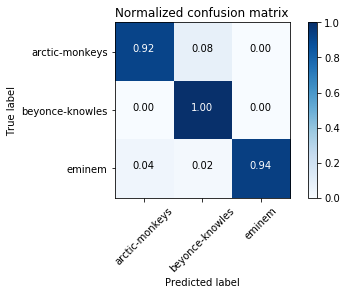

In [178]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

class_names = list(le.classes_)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()